# Training Images Optimal Transport Benchmarks
ConvICNN64-based benchmark training by W2GN solver.
**GPU-only implementation.**

In [1]:
import os, sys
sys.path.append("..")

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

import numpy as np
import torch
import gc

from sklearn.decomposition import PCA

from src import distributions
from src import map_benchmark as mbm

from src.icnn import ConvICNN64
from src.tools import train_identity_map, unfreeze, load_resnet_G
from src.plotters import plot_benchmark_emb, plot_W2, plot_benchmark_images

from tqdm import tqdm
from IPython.display import clear_output

## Changable Config

In [2]:
BATCH_SIZE = 64
MAX_ITER = 50001

VERSION = "v2" # v1
WHICH = "Early" # Mid, Late

GPU_DEVICE = 1

## Hardcoded Config

In [4]:
BENCHMARK = 'CelebA64'
LAMBDA = 10000
LR = 3 * 1e-4
DIM = 64*64*3

OUTPUT_PATH = '../benchmarks/' + BENCHMARK
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)

assert torch.cuda.is_available()
torch.cuda.set_device(GPU_DEVICE)
torch.manual_seed(0x000000); np.random.seed(0x000000)

## Initializing input and output distributions

In [5]:
print('Preparing input sampler')
input_cpkt = '../benchmarks/CelebA64/Final_G.pt'
resnet_in = load_resnet_G(input_cpkt, verbose=True)
input_sampler = distributions.NormalNoiseTransformer(std=0.01).fit(
    distributions.PushforwardTransformer(resnet_in, batch_size=BATCH_SIZE).fit(
        distributions.StandardNormalSampler(dim=128), estimate_cov=False
    )
)

print('Preparing output sampler')
output_cpkt = f'../benchmarks/CelebA64/{WHICH}_G_{VERSION}.pt'
resnet_out = load_resnet_G(output_cpkt, verbose=True)
output_sampler = distributions.NormalNoiseTransformer(std=0.01).fit(
    distributions.PushforwardTransformer(resnet_out, batch_size=BATCH_SIZE).fit(
        distributions.StandardNormalSampler(dim=128), estimate_cov=False
    )
)

print('Preparing benchmark')
benchmark = mbm.Wasserstein2MapBenchmark(input_sampler, output_sampler, compute_linear=False)
emb_X = PCA(n_components=2).fit(benchmark.input_sampler.sample(2**14).cpu().detach().numpy())
emb_Y = PCA(n_components=2).fit(benchmark.output_sampler.sample(2**14).cpu().detach().numpy())

Preparing input sampler
Loading ResNet generator checkpoint from ../benchmarks/CelebA64/Final_G.pt
Warming up the generator



ResNet has been succesfully loaded!
Preparing output sampler
Loading ResNet generator checkpoint from ../benchmarks/CelebA64/Early_G_v2.pt
Warming up the generator



ResNet has been succesfully loaded!
Preparing benchmark


## Potentials Setup

Training the potentials to satisfy push(x)=x



Pretraining identity potential. Final MSE: 0.0009985215729102492


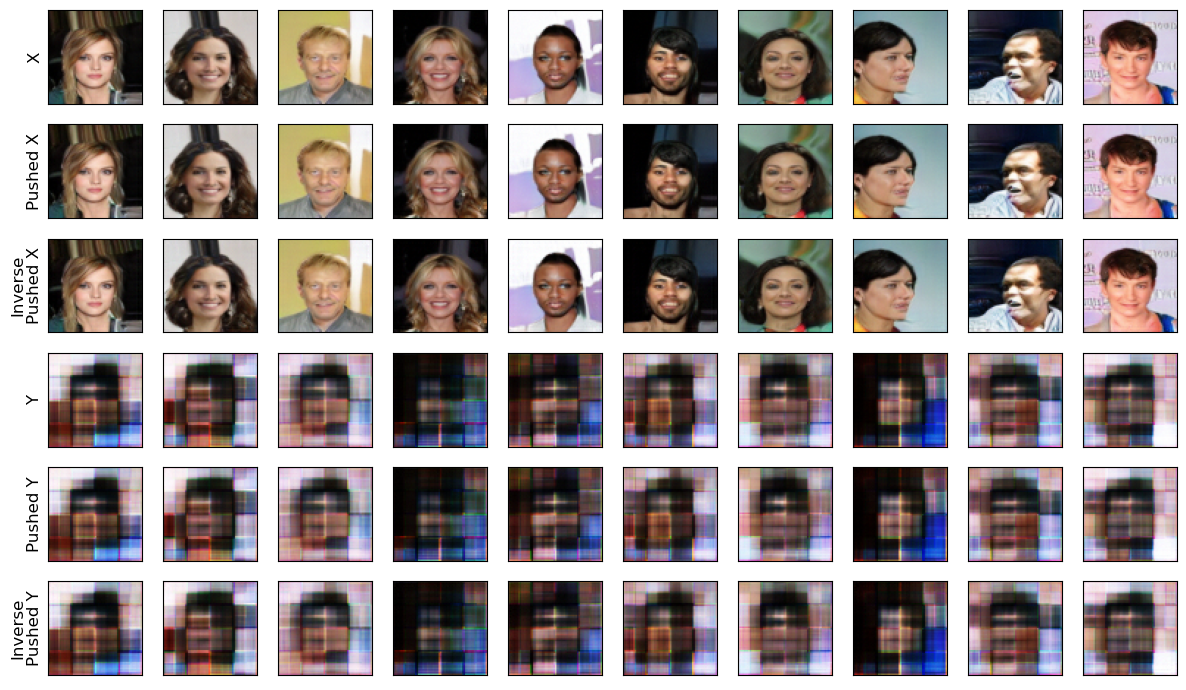

In [6]:
D = ConvICNN64().cuda()
D_conj = ConvICNN64().cuda()
    
pretrain_sampler = distributions.CubeUniformSampler(DIM, centered=True)
print(
    'Pretraining identity potential. Final MSE:',
    train_identity_map(D, pretrain_sampler, BATCH_SIZE, max_iter=1000, tol=1e-3, blow=4, convex=True, verbose=True)
)
D_conj.load_state_dict(D.state_dict())
del pretrain_sampler

fig, axes = plot_benchmark_images(benchmark, D, D_conj)

## Main training

In [7]:
D_opt = torch.optim.Adam(D.parameters(), lr=LR, betas=(0.8, 0.99))
D_conj_opt = torch.optim.Adam(D_conj.parameters(), lr=LR, betas=(0.4, 0.4))

In [8]:
W2_history = []

Iteration 50000


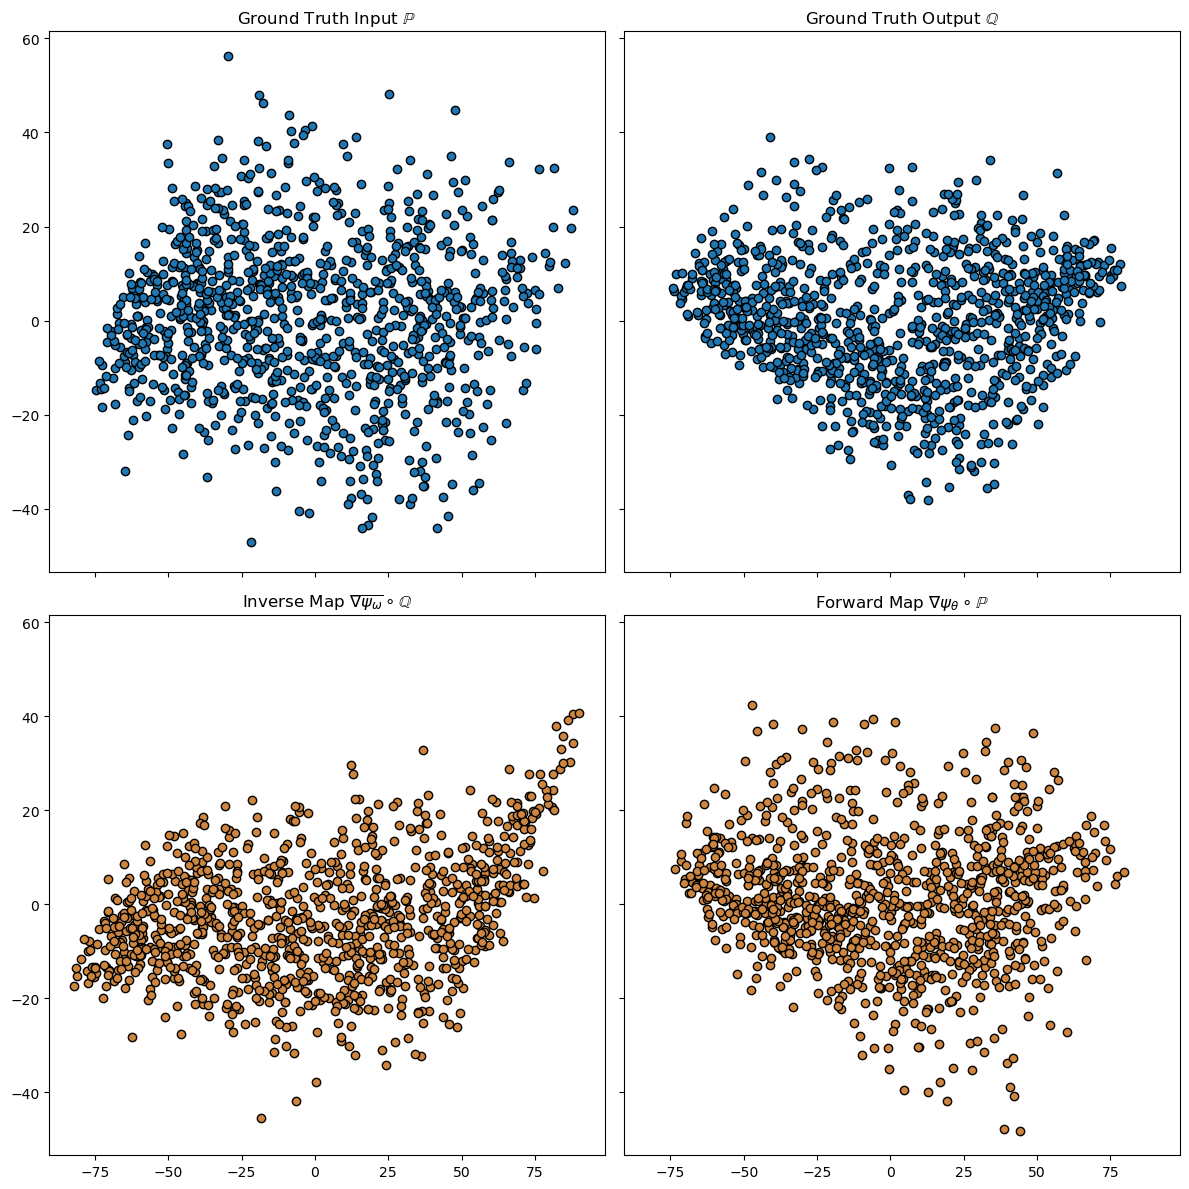

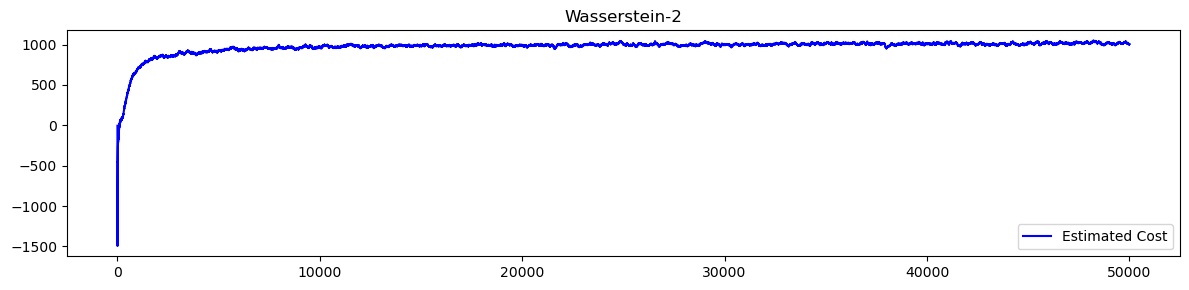

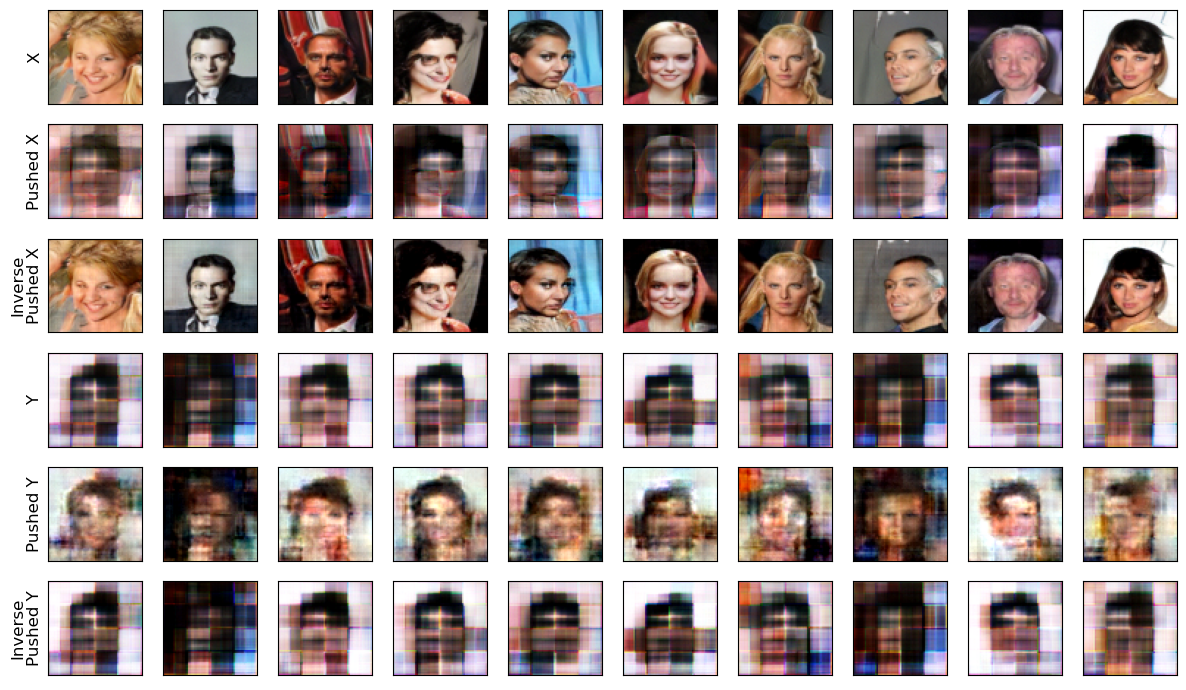

100%|█████████████████████████████████████████████████████████████████████████████████████████| 50001/50001 [14:21:12<00:00,  1.03s/it]


In [9]:
print('Fitting the monotone generative mapping')
for iteration in tqdm(range(MAX_ITER)):
    unfreeze(D); unfreeze(D_conj)
    
    X = benchmark.input_sampler.sample(BATCH_SIZE)
    X.requires_grad_(True)
    Y = benchmark.output_sampler.sample(BATCH_SIZE)
    Y.requires_grad_(True)

    # Negative Wasserstein distance
    Y_inv = D_conj.push(Y).detach()
    D_opt.zero_grad()
    D_conj_opt.zero_grad()    
    W_loss = (D(X) - D(Y_inv)).mean()
    
    # Non-backpropagated part
    with torch.no_grad():
        W_loss_nograd = (- (X ** 2).sum(dim=1) / 2).mean() +\
        ((Y_inv * Y).sum(dim=1) - (Y_inv ** 2).sum(dim=1) / 2 ).mean()
        
    # Cycle Regularization
    cycle_loss = ((D.push(D_conj.push(Y)) - Y.detach()) ** 2).mean()
    cycle_loss += ((D_conj.push(D.push(X)) - X.detach()) ** 2).mean()
    W_loss += LAMBDA * cycle_loss
    
    W2_history.append(-W_loss.item() - W_loss_nograd.item())

    W_loss.backward()
    D_opt.step(); D_conj_opt.step()
    D_opt.zero_grad(); D_conj_opt.zero_grad()
    D.convexify(); D_conj.convexify()    
                    
    if iteration % 1000 == 0:
        clear_output(wait=True)
        print("Iteration", iteration)
        
        fig, axes = plot_benchmark_emb(benchmark, emb_X, emb_Y, D, D_conj)
        plt.show(fig); plt.close(fig)
        
        fig, ax = plot_W2(benchmark, W2_history)
        plt.show(fig); plt.close(fig)
        
        fig, axes = plot_benchmark_images(benchmark, D, D_conj)
        plt.show(fig); plt.close(fig)

In [10]:
print(f'Saving benchmark model checkpoints to {OUTPUT_PATH}')
D.convexify(); D_conj.convexify()
torch.save(D.state_dict(), os.path.join(OUTPUT_PATH, f'{WHICH}_{VERSION}.pt'))
torch.save(D_conj.state_dict(), os.path.join(OUTPUT_PATH, f'{WHICH}_{VERSION}_conj.pt'))
print('Done!')

Saving benchmark model checkpoints to ../benchmarks/CelebA64
Done!
